# Tomato Disease Classification

Import all the dependencies

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the constants

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

Import data into tensorflow dataset object

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from tensorflow.keras.utils import get_file
import pathlib
from glob import glob

data_path = "/Users/kasuntharu/Documents/python_projects/tomato_data"

folders = glob("/Users/kasuntharu/Documents/python_projects/tomato_data*")

In [8]:
folders

['/Users/kasuntharu/Documents/python_projects/tomato_data']

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Use flow_from_directory to load images from the local directory (mounted Google Drive)
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Use take method on the Dataset
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


Found 8031 files belonging to 5 classes.
(32, 224, 224, 3)
[1 4 3 4 0 2 3 0 0 4 4 2 4 2 0 0 3 3 0 4 4 2 3 0 3 0 0 0 4 0 2 3]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [10]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Tomato_healthy']

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[4 1 2 4 0 4 4 3 4 2 2 2 3 0 2 3 4 2 3 2 0 2 2 3 4 0 0 1 2 2 3 2]


Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

**Visualize some of the images from our dataset

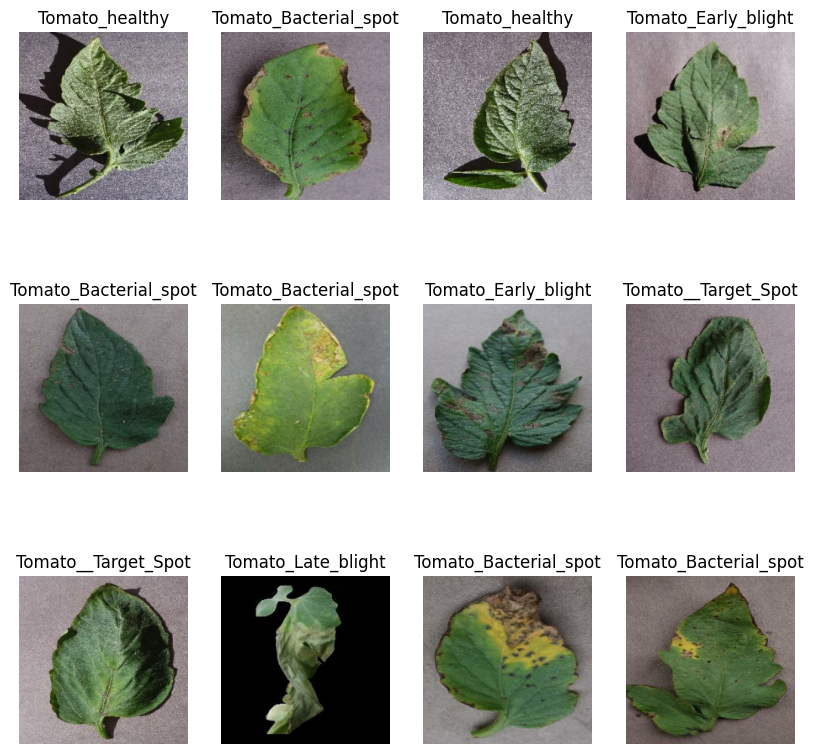

In [12]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


Split dataset

In [13]:
len(dataset)

251

In [14]:
train_size = 0.8
len(dataset)*train_size

200.8

In [15]:
train_ds = dataset.take(200)
len(train_ds)

200

In [16]:
test_ds = dataset.skip(200)
len(test_ds)

51

In [17]:
val_size = 0.1
len(dataset)*val_size

25.1

In [18]:
val_ds = test_ds.take(25)
test_ds = test_ds.skip(25)

In [19]:
len(val_ds)

25

In [20]:
len(test_ds)

26

In [21]:
def get_dataset_partition_df(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_da, test_ds = get_dataset_partition_df(dataset)

In [23]:
len(train_ds)

200

In [24]:
len(val_ds)

25

In [25]:
len(test_ds)

26

Cache, shuffle and prefetch the dataset

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Building the model

Creating a layer for resizing and normalization


Before feed images to network, should be resizing it to the desired size. Moreover, to improve model performance, should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence can add that as a layer in Sequential Model.

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

Model Architecture

Use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [30]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CHANNELS = 3  # Assuming RGB images

# Assuming you have already defined IMAGE_SIZE and CHANNELS
target_size = (IMAGE_SIZE[0], IMAGE_SIZE[1])

# Create a Sequential model
model = models.Sequential([
    # Resize images to the target size
    layers.Resizing(*target_size),

    # Data augmentation
    layers.experimental.preprocessing.Rescaling(1./255),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], CHANNELS)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),

    # Output layer
    layers.Dense(5, activation="softmax")
])



In [31]:
# Build the model with a specified input shape
model.build(input_shape=(None, target_size[0], target_size[1], CHANNELS))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

Compiling the model

Use adam optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [34]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    epochs = 25,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
200/200 [==============================] - 90s 436ms/step - loss: 1.2376 - accuracy: 0.4859 - val_loss: 0.8016 - val_accuracy: 0.7025
Epoch 2/25
200/200 [==============================] - 94s 470ms/step - loss: 0.6933 - accuracy: 0.7442 - val_loss: 0.5774 - val_accuracy: 0.7700
Epoch 3/25
200/200 [==============================] - 99s 495ms/step - loss: 0.5057 - accuracy: 0.8167 - val_loss: 0.3957 - val_accuracy: 0.8425
Epoch 4/25
200/200 [==============================] - 104s 520ms/step - loss: 0.3696 - accuracy: 0.8661 - val_loss: 0.3318 - val_accuracy: 0.8800
Epoch 5/25
200/200 [==============================] - 96s 481ms/step - loss: 0.3498 - accuracy: 0.8697 - val_loss: 0.3713 - val_accuracy: 0.8600
Epoch 6/25
200/200 [==============================] - 99s 492ms/step - loss: 0.3256 - accuracy: 0.8792 - val_loss: 0.2755 - val_accuracy: 0.8963
Epoch 7/25
200/200 [==============================] - 96s 480ms/step - loss: 0.2858 - accuracy: 0.8937 - val_loss: 0.3561 - val_a

In [36]:
score = model.evaluate(test_ds)

26/26 [==============================] - 7s 113ms/step - loss: 0.2657 - accuracy: 0.9255


In [37]:
score

[0.26574379205703735, 0.9254807829856873]

Plotting the Accuracy and Loss curves

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 200}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
history.history['accuracy']

[0.48585715889930725,
 0.7441787719726562,
 0.8166900873184204,
 0.8660728335380554,
 0.869667112827301,
 0.8791998624801636,
 0.8937333822250366,
 0.907329261302948,
 0.9018596410751343,
 0.9251445531845093,
 0.9301453232765198,
 0.9237380623817444,
 0.9376465082168579,
 0.9365525841712952,
 0.9459290504455566,
 0.9446788430213928,
 0.9453039765357971,
 0.9446788430213928,
 0.957962155342102,
 0.9587435722351074,
 0.9540553092956543,
 0.9565557241439819,
 0.9626504182815552,
 0.9679637551307678,
 0.9626504182815552]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and VAlidation loss')

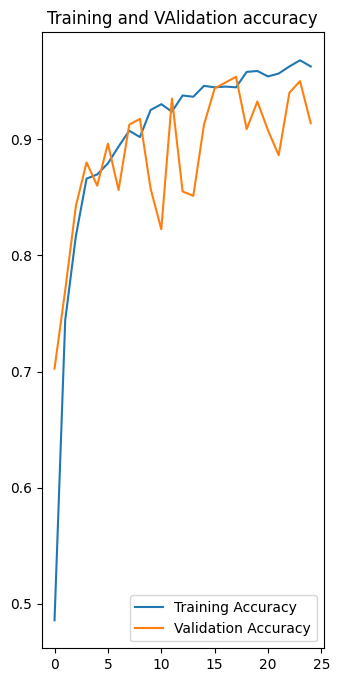

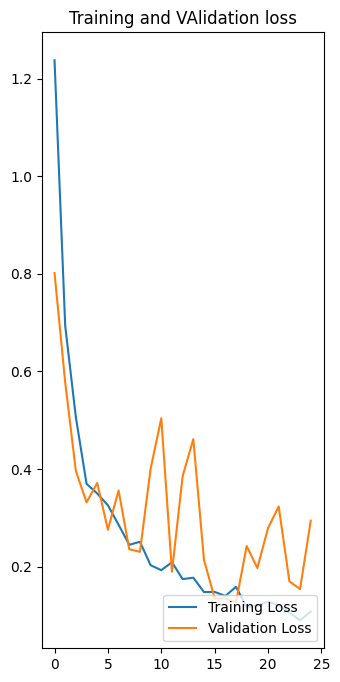

In [60]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(25), acc, label = "Training Accuracy")
plt.plot(range(25), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and VAlidation accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(25), loss, label = "Training Loss")
plt.plot(range(25), val_loss, label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and VAlidation loss")

Run prediction on a sample image

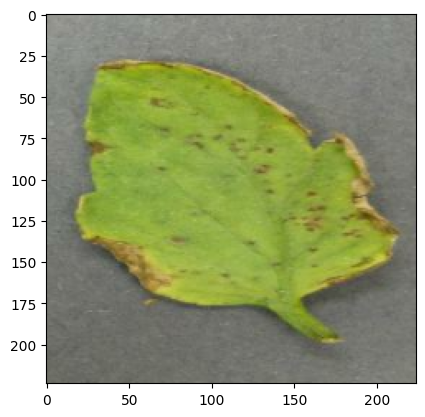

In [44]:
for images_batch, labels_batch in test_ds.take(1):

    plt.imshow(images_batch[0].numpy().astype('uint8'))

first image to predict
first image's actual label:  Tomato__Target_Spot
1/1 [==============================] - 0s 171ms/step
predicted label :  Tomato__Target_Spot


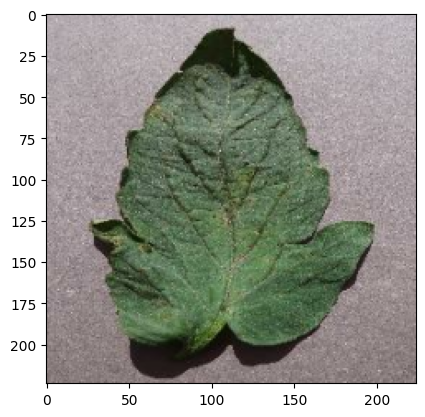

In [45]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

Function for inference

In [46]:
def predict(model, imges):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


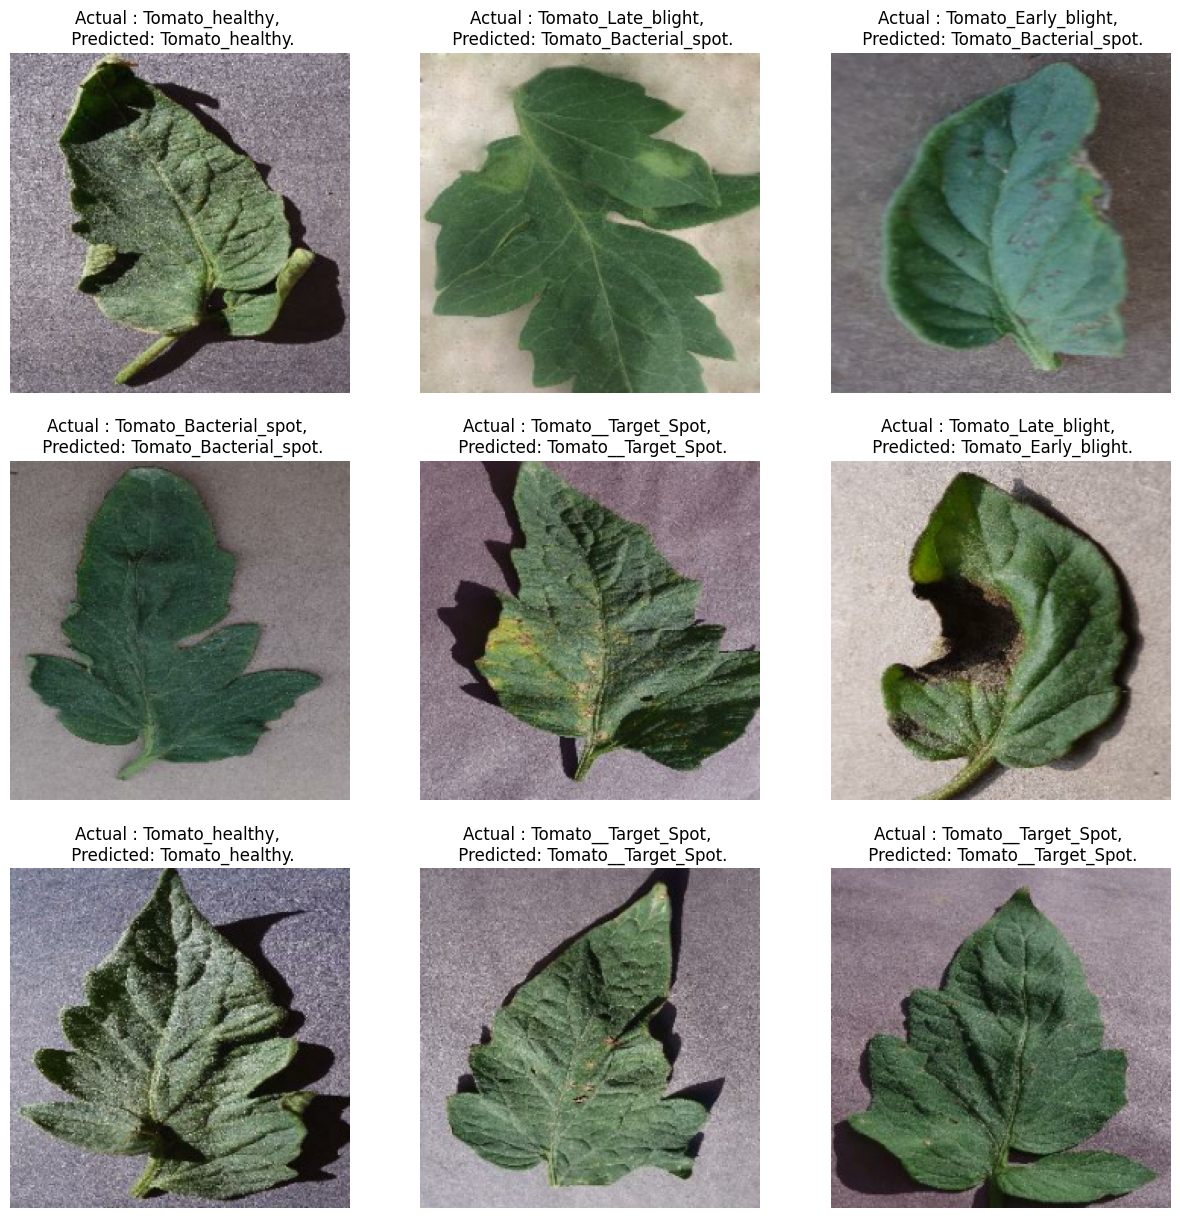

In [47]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")

In [52]:
model_version = 1
model.save(f'model{model_version}')

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


In [53]:
!pwd

/Users/kasuntharu/Downloads/model
